Tutorial source: https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
Source for the ATIS data set: https://www.kaggle.com/siddhadev/atis-dataset-from-ms-cntk/data

DEF: a TRANSFORMER is a network that applies attention mechanisms to gather information about the relevant context of a given word, and then encode that context in a vector that smartly represents the word.

DEF: BERT (Bidirectional Encoder Representations from Transformers) is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a re- sult, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models.

In [1]:
import os
import pandas as pd
import pickle

# load Pickle file 
def load_ds(fname, verbose=True):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    if verbose:
      print('Done  loading: ', fname)
      print('      samples: {:4d}'.format(len(ds['query'])))
      print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
      print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
      print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts
#load_ds(os.path.join("atis","atis.train.pkl"))


In [3]:
import numpy as np

# convert Pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join("atis",filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
          print('Query text:', q)
          print('Query vector: ', query[i])
          print('Intent label: ', i2in[intent[i][0]])
          print('Slot text: ', slot)
          print('Slot vector: ', slot_vector)
          print('*'*74)
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data

In [4]:
# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, input_tensor_train, target_tensor_train, query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

Done  loading:  atis/atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS oakland to philadelphia saturday EOS
Query vector:  [178 644 851 678 740 179]
Intent label:  flight
Slot text:  O B-fromloc.city_name O B-toloc.city_name B-depart_date.day_name O
Slot vector:  [128, 48, 128, 78, 26, 128]
**************************************************************************
Query text: BOS now i 'd like to see flights from detroit to st. petersburg on the next tuesday EOS
Query vector:  [178 637 479   0 545 851 754 429 444 361 851 789 677 654 827 621 874 179]
Intent label:  flight
Slot text:  O O O O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O O B-depart_date.date_relative B-depart_date.day_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 128, 128, 128, 48, 128, 78, 125, 128, 128, 25, 26, 128]
**************************************************************************
Query text: BOS i need information for f

In [5]:
# load ATIS testing dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, input_tensor_test, target_tensor_test, query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')

Done  loading:  atis/atis.test.pkl
      samples:  893
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS monday morning i would like to fly from columbus to indianapolis EOS
Query vector:  [178 601 606 479 932 545 851 431 444 312 851 489 179]
Intent label:  flight
Slot text:  O B-depart_date.day_name B-depart_time.period_of_day O O O O O O B-fromloc.city_name O B-toloc.city_name O
Slot vector:  [128, 26, 33, 128, 128, 128, 128, 128, 128, 48, 128, 78, 128]
**************************************************************************
Query text: BOS find nonstop flights from salt lake city to new york on saturday april ninth EOS
Query vector:  [178 423 629 429 444 736 521 301 851 619 937 654 740 227 626 179]
Intent label:  flight
Slot text:  O O B-flight_stop O O B-fromloc.city_name I-fromloc.city_name I-fromloc.city_name O B-toloc.city_name I-toloc.city_name O B-depart_date.day_name B-depart_date.month_name B-depart_date.day_number O
Slot vector:  [128, 128, 44, 1

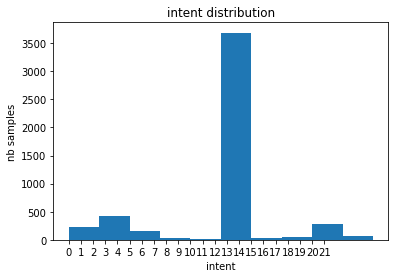

In [7]:
import matplotlib.pyplot as plt

labels = intent_data_label_train
plt.hist(labels)
plt.xlabel('intent')
plt.ylabel('nb samples')
plt.title('intent distribution')
plt.xticks(np.arange(len(np.unique(labels))));

In [9]:
# BERT imports
import torch
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
#from pytorch_transformers.tokenization_bert import BertTokenizer, BertConfig
#from pytorch_transformers.modeling_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


/Users/giudittaparolini/anaconda3/envs/transformers/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/giudittaparolini/anaconda3/envs/transformers/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/giudittaparolini/anaconda3/envs/transformers/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

In [10]:
# add special tokens for BERT to work properly
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[0])

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

[CLS]  i want to fly from boston at 838 am and arrive in denver at 1110 in the morning  [SEP]
Tokenize the first sentence:
['[CLS]', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', '[SEP]']


In [11]:
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [12]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [13]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [22]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [23]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
#model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=labels)
#model.cuda()



In [24]:
from transformers import AdamW,get_linear_schedule_with_warmup

# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5,
                     #warmup=.1
                 )

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /Users/distiller/project/conda/conda-bld/pytorch_1573049308345/work/aten/src/THNN/generic/ClassNLLCriterion.c:97